## License Information
---

This file is distributed as part of _swprocess_, a Python package for surface wave processing.

    Copyright (C) 2020 Joseph P. Vantassel (joseph.p.vantassel@gmail.com)

    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <https: //www.gnu.org/licenses/>.
    
## About _swprocess_ and this notebook
---

_swprocess_ is a Python package for surface wave processing. _swprocess_ was developed by
Joseph P. Vantassel under the supervision of Professor Brady R. Cox at The University of
Texas at Austin.

If you use _swprocess_ in your research or consulting, we ask you please cite the following:

> Vantassel, J. P. (2021). jpvantassel/swprocess: latest (Concept). Zenodo.
> [https://doi.org/10.5281/zenodo.4584128](https://doi.org/10.5281/zenodo.4584128)

> Vantassel, J. P. & Cox, B. R. (2022). "SWprocess: a workflow for developing robust
> estimates of surface wave dispersion uncertainty". Journal of Seismology.
> [https://doi.org/10.1007/s10950-021-10035-y](https://doi.org/10.1007/s10950-021-10035-y)

_Note: For software, version specific citations should be preferred to
general concept citations, such as that listed above. To generate a version
specific citation for _swprocess_, please use the citation tool on the _swprocess_
[archive](https://doi.org/10.5281/zenodo.4584128)._

This notebook facilities the interactive trimming and calculation of dispersion statistics
described in Vantassel and Cox (2022), citation above. The input `.json` data files were
produced using the `mam_fk.ipynb` and `masw.ipynb` provided as a part of this package.

The data presented in this notebook is from the WGHS site in Wellington, NZ. The data
has been archived and made publically on the DesignSafe-CI by Cox and Vantassel (2018),
full citation and link to the data below.

> Cox, B. R. & Vantssel, J. P. (2018). Dynamic Characterization of Wellington, New Zealand
> [Dataset].DesignSafe-CI [publisher]. https://doi.org/10.17603/DS24M6J

## Getting Started
---
1. Install _swprocess_ and its dependencies, with `pip install swprocess`. If you are not familiar with `pip`, a useful tutorial can be found [here](https://jpvantassel.github.io/python3-course/#/intro/pip). __(~3 minutes)__ 
2. Execute the notebook to perform interactive trimming and calculate dispersion statistics on the raw Rayleigh dispersion data. The trimmed experimental dispersion data can be saved for lateruse in the `JSON` format. The dispersion statistics are saved into the `.txt` format in a format easily read by Dinver v2. __(~30 minutes)__
3. Repeat the process for the raw Love dispersion data. __(~20 minutes)__
4. Use the notebook to interactively trim and calculate statistics for your next project.

Happy Processing!

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import swprocess
import swprepost

## Input
---

### Files

In [2]:
# File(s) in the .json format to import. These files are produced as the output of the mam.ipynb and the masw.ipynb. You may also wish
# to load .jsom files which contain the interatively trimmed experimental dispersion data produced by this notebook. See below for details.

# Raw Rayleigh data
fnames_set = [
    ["../masw/hb_hammer_masw.json"],
    ["../masw/hb_thumper_masw.json"],
    ["../masw/hb_trex_masw.json"],
    ]

### Plot Settings

In [3]:
# Domains in which to plot the experimental dispersion data.
domains = [
    ["frequency", "velocity"],
    ["wavelength", "velocity"],
]

# Colors one per `fnames_set` entry. Examples include: "limegreen", "dodgerblue", "darkblue", "tomato", "pink", "limegreen", "darkorange".
# A full listing is provided here: https://matplotlib.org/3.1.0/_images/sphx_glr_named_colors_003.png
# Colors may also be listed in hexidecimal.
colors = ["red", "blue", "green"]

# Labels one per `fnames_set` entry.
labels = ["Hammer", "Thumper", "T-Rex"]

## View Raw Data
---

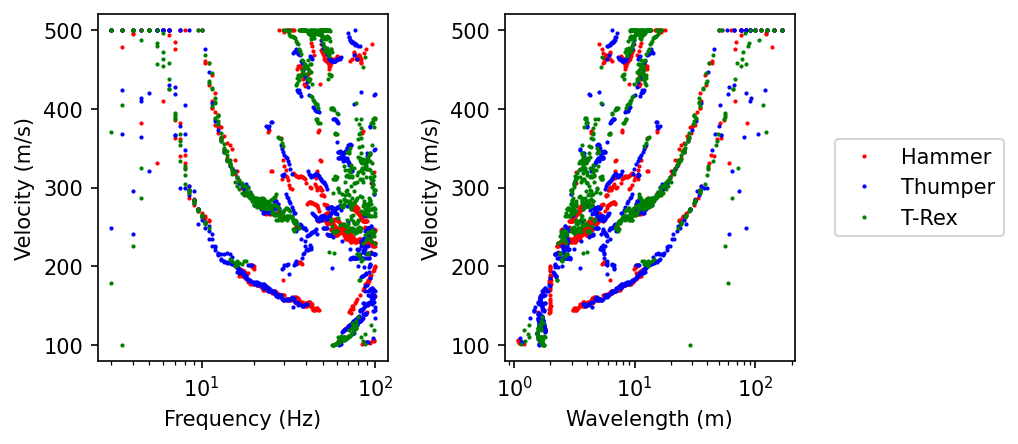

In [4]:
%matplotlib inline
xtype = [x for x, _ in domains]
ytype = [y for _, y in domains]

if len(fnames_set) != len(colors) or len(fnames_set) != len(labels):
    raise IndexError(f"fnames_set, colors, and labels must be the same length.")

fig, axs = plt.subplots(ncols=len(xtype), figsize=(6,3), dpi=150, gridspec_kw=dict(wspace=0.4))
suites = []
for fnames, color, label in zip(fnames_set, colors, labels):
    peaksuite = swprocess.PeaksSuite.from_json(fnames=fnames)
    peaksuite.plot(xtype=xtype, ax=axs, ytype=ytype, plot_kwargs=dict(color=color, label=label))
    suites.append(peaksuite)
    
axs[-1].legend(bbox_to_anchor = (1.1, 0.5), loc="center left")

# # manually set limits for first panel (frequency in this case)
# axs[0].set_xlim(0.1, 50)
# axs[0].set_ylim(0, 1000)

# # manually set limits for second panel (wavelength in this case)
# axs[1].set_xlim(0.1, 1000)
# axs[1].set_ylim(0, 1000)

plt.show()

main_suite = swprocess.PeaksSuite.from_peakssuite(suites)
_colors, _labels = [], []
for color, label, suite in zip(colors, labels, suites):
    for _ in range(len(suite)):
        _colors.append(color)
        _labels.append(label)
        label = None


## Interactive Trimming
---

### Workflow

In [5]:
# Workflow for interactive trimming {"individual", "together"}, "individual" is recommended.
workflow = "together"

### Array Resolution Limits

In [6]:
# Resolution limits, one per entry in fnames_set. Ingored if workflow="together".
individual_resolution_limits = [
    ["wavelength", (4, 96)],
    ["wavelength", (4, 96)],
    ["wavelength", (4, 96)],
]

# Overall minimumm and maximum array resolution, only one entry permitted.
overall_resolution_limits = ["wavelength", (4, 96)]

### Bulk Trimming

In [7]:
# Bulk remove points outside of the specified screening criteria. Use `None` for one sided intervals. Multiple entries permitted.
bulk_trimming_limits = {
    "velocity" : [None, None],
}

### Launch

In [8]:
%matplotlib qt5
for suite in suites:
    for attribute, limits in bulk_trimming_limits.items():
        suite.reject_limits_outside(attribute, limits)        

if workflow == "individual":
    if len(fnames_set) != len(individual_resolution_limits):
        raise IndexError(f"individidual_resolution_limits must have the same length as fnames_set.")

    for suite, color, label, _resolution_limits in zip(suites, colors, labels, individual_resolution_limits):
        suite.interactive_trimming(xtype=xtype, ytype=ytype, plot_kwargs=dict(color=color, label=label), resolution_limits=_resolution_limits)

main_suite.interactive_trimming(xtype=xtype, ytype=ytype, plot_kwargs=dict(color=_colors, label=_labels), resolution_limits=overall_resolution_limits)

C:\Users\vanta\Documents\trainings\2024_07_us_vs\venv\lib\site-packages\swprocess\peaks.py:400: UserWarning: `reject_outside` called, but limits were both `None`, therefore no values were rejected.
  warnings.warn(msg)


Enter (0 to quit, 1 to continue, 2 to undo):  1
Enter (0 to quit, 1 to continue, 2 to undo):  0


## Plot Data Post Trimming
---

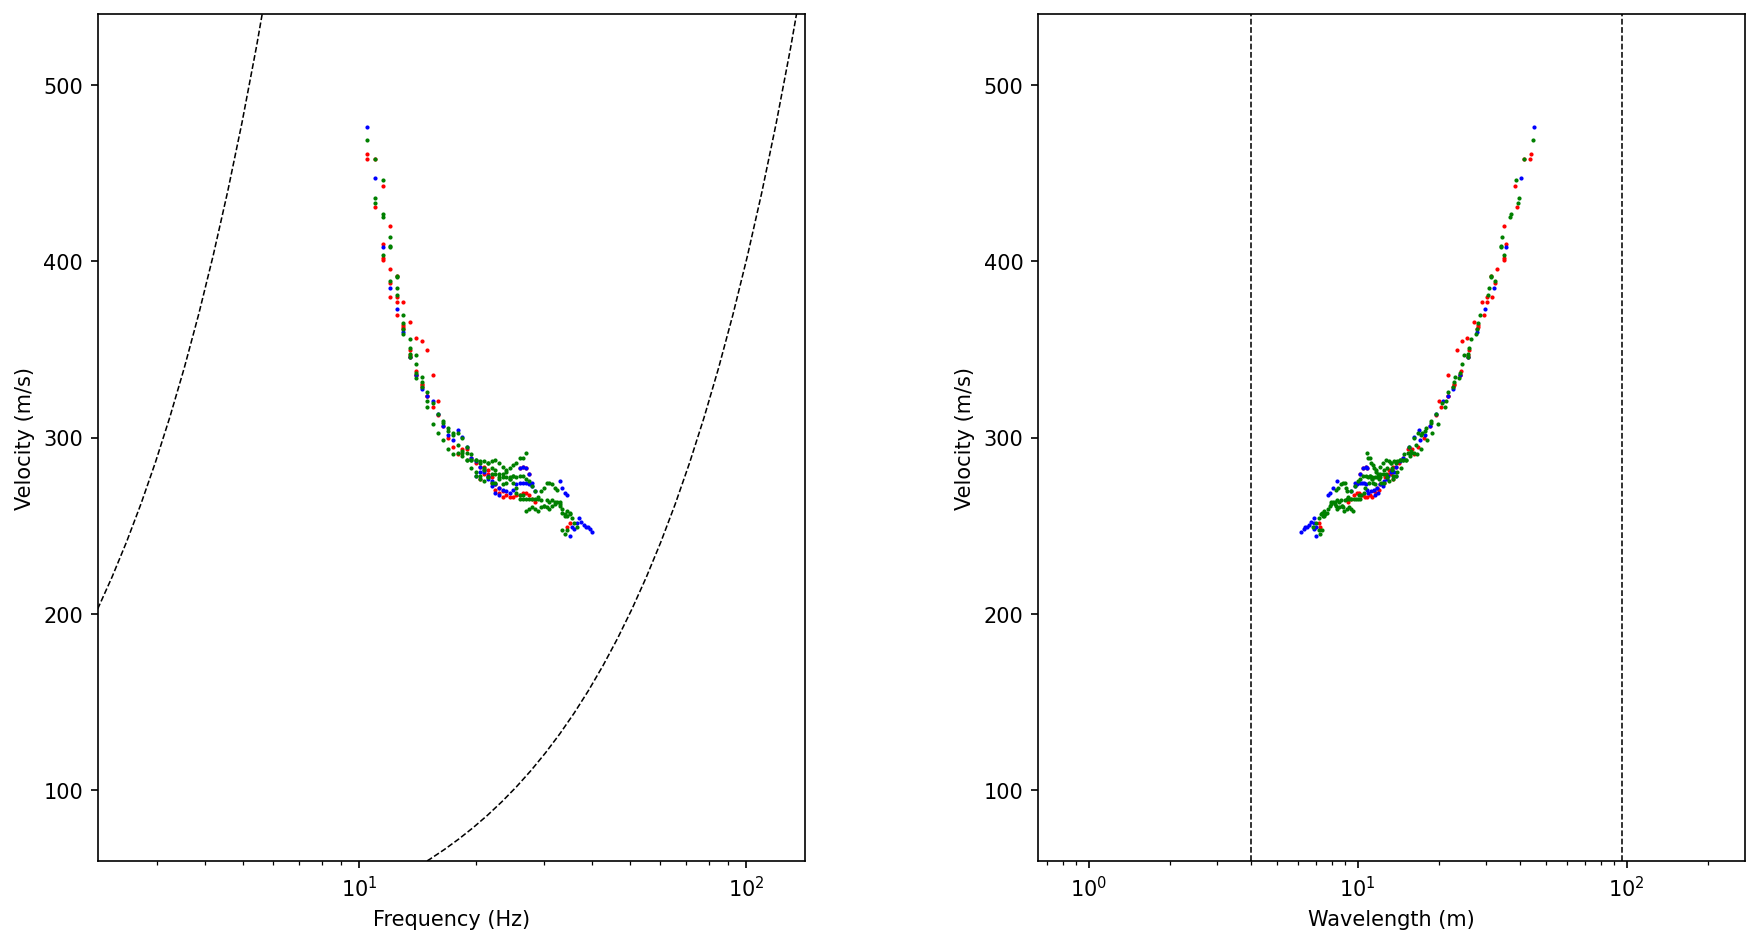

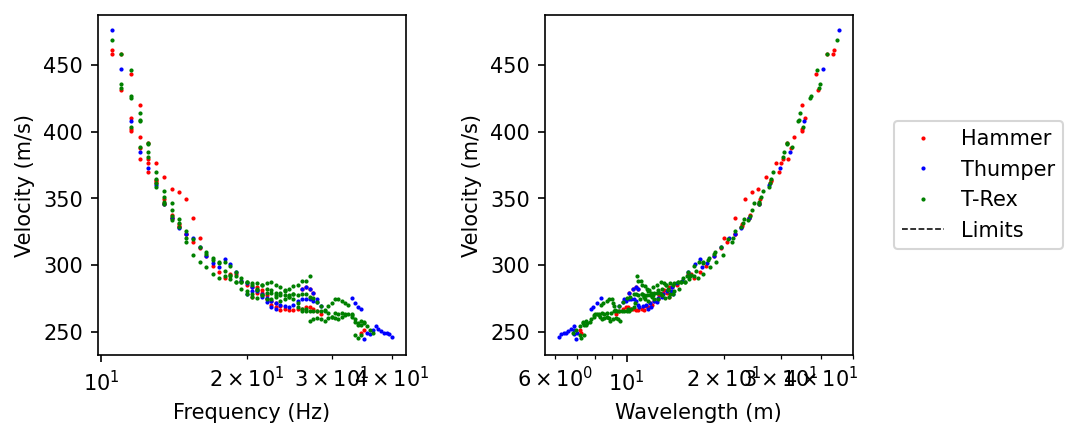

In [9]:
%matplotlib inline
fig, axs = main_suite.plot(xtype=xtype, ytype=ytype, plot_kwargs=dict(color=_colors, label=_labels))

for ax in axs:
    ax.autoscale(enable=True)

for ax, _xtype, _ytype in zip(axs, xtype, ytype):
    xlim, ylim = ax.get_xlim(), ax.get_ylim()
    attribute, limits = overall_resolution_limits
    main_suite.plot_resolution_limits(ax=ax, xtype=_xtype, ytype=_ytype, attribute=attribute, limits=limits, plot_kwargs=dict(label="Limits"))
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
axs[-1].legend(bbox_to_anchor = (1.1, 0.5), loc="center left")

plt.show()

## Statistics
---


### Input

In [10]:
# Domain in which to calculate statistics.
xdomain, ydomain = "wavelength", "velocity"

# Statistic calculation points.
xmin, xmax, nx, xspace = 1, 1000, 40, "log"

### Plot

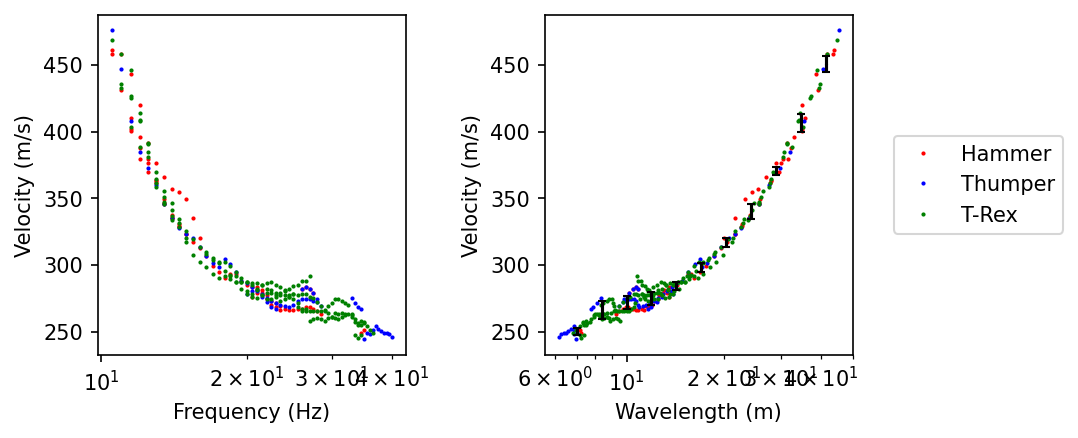

In [11]:
%matplotlib inline

xx = swprocess.wavefieldtransforms.AbstractWavefieldTransform._create_vector(pmin=xmin, pmax=xmax, pn=nx, pspace=xspace)
xx, mean, stddev, _ = main_suite.statistics(xtype=xdomain, ytype=ydomain, xx=xx, ignore_corr=True, drop_sample_if_fewer_count=1)

fig, axs = main_suite.plot(xtype=xtype, ytype=ytype, plot_kwargs=dict(color=_colors, label=_labels))

for ax, _xtype, _ytype in zip(axs, xtype, ytype):
    if _xtype == xdomain and _ytype == ydomain:
        main_suite.plot_statistics(ax=ax, xx=xx, mean=mean, stddev=stddev)
        
# # manually set limits for first panel (frequency in this case)
# axs[0].set_xlim(0.1, 50)
# axs[0].set_ylim(0, 1000)

# # manually set limits for second panel (wavelength in this case)
# axs[1].set_xlim(0.1, 1000)
# axs[1].set_ylim(0, 1000)

axs[-1].legend(bbox_to_anchor = (1.1, 0.5), loc="center left")

plt.show()

### Write Experimental Dispersion Curve to `.txt`

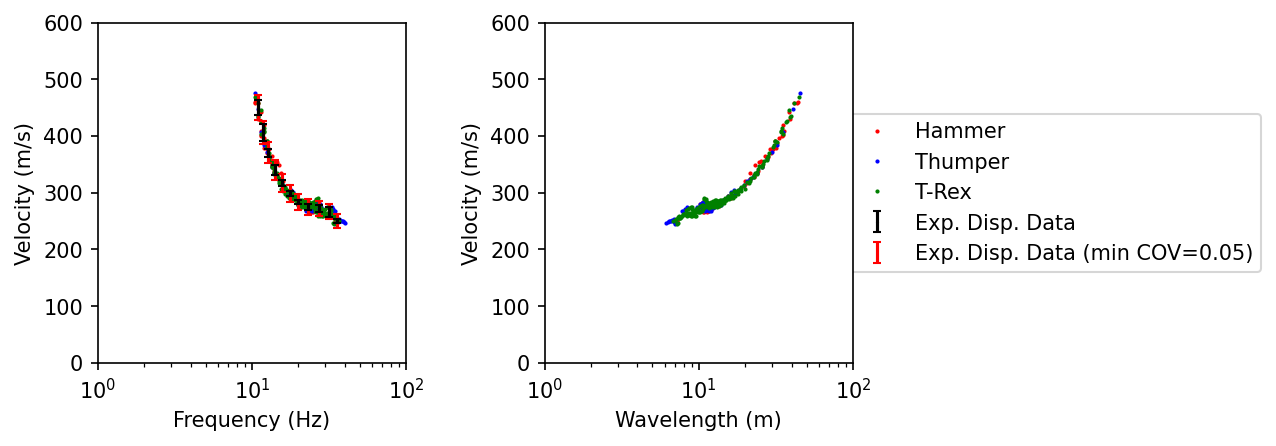

In [12]:
fname = "hb_masw_r1.txt"
version = "3.4.2"
minimum_cov = 0.05

if xdomain == "frequency" and ydomain == "velocity":
    new_xx = np.array(xx)
    new_mean = np.array(mean)
    new_stddev = np.array(stddev)
elif xdomain == "wavelength" and ydomain == "velocity":
    new_xx = mean/xx
    new_mean = np.array(mean)
    upper = swprepost.Curve(x=(mean+stddev)/xx, y=mean+stddev)
    lower = swprepost.Curve(x=(mean-stddev)/xx, y=mean-stddev)
    new_stddev = ((upper.resample(xx=new_xx, interp1d_kwargs=dict(fill_value="extrapolate"))[1] - new_mean) + (new_mean - lower.resample(xx=new_xx, interp1d_kwargs=dict(fill_value="extrapolate"))[1])) /2
else:
    raise NotImplementedError()
    
%matplotlib inline
fig, axs = main_suite.plot(xtype=xtype, ytype=ytype, plot_kwargs=dict(color=_colors, label=_labels))

for ax, _xtype, _ytype in zip(axs, xtype, ytype):
    if _xtype == "frequency" and _ytype == "velocity":
        main_suite.plot_statistics(ax=ax, xx=new_xx, mean=new_mean, stddev=new_stddev, errorbar_kwargs=dict(label="Exp. Disp. Data"))

for index, _stddev in enumerate(new_stddev):
    if np.isnan(_stddev):
        new_stddev[index] = 0

target = swprepost.Target(frequency=new_xx, velocity=new_mean, velstd=new_stddev)
target.setmincov(minimum_cov)
ylabel = axs[0].get_ylabel()
target.plot(ax=axs[0], errorbarkwargs=dict(color="r", label=f"Exp. Disp. Data (min COV={minimum_cov})"))
axs[0].set_ylabel(ylabel)
target.to_txt_dinver(fname=fname, version=version)

axs[0].legend(bbox_to_anchor = (2.4, 0.5), loc="center left")

# manually set limits for first panel (frequency in this case)
axs[0].set_xlim(1, 100)
axs[0].set_ylim(0, 600)

# manually set limits for second panel (wavelength in this case)
axs[1].set_xlim(1, 100)
axs[1].set_ylim(0, 600)

plt.show()

## Write Trimmed Experimental Dispersion Data to `.json`
---

### Input

In [13]:
# File contents {"together", "indivdual"}.
# "together" all sets are combined into a single file.
# "individual" all sets are saved to separate files.
file_contents = "individual"

# Output prefix.
output_prefix = "hb_masw_trim_r1"

# If file_contents == "indivdual", define unique suffixes for each output file.
output_suffixes = ["hammer", "thumper", "trex"]

### Write

In [14]:
if file_contents == "together":
    main_suite.to_json(f"{output_prefix}.json")
else:
    if len(output_suffixes) != len(suites):
        raise IndexError(f"suites and indivdual suffixes are of different length.")
    for suite, suffix in zip(suites, output_suffixes):
        suite.to_json(f"{output_prefix}_{suffix}.json")